In [1]:
import sympy as sym
from IPython.display import display
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt



# ###################################################################
def cubic_spline_clamped(
    xs: list[float], ys: list[float], B0: float, B1: float
) -> list[sym.Symbol]:
    """
    Cubic spline interpolation ``S``. Every two points are interpolated by a cubic polynomial
    ``S_j`` of the form ``S_j(x) = a_j + b_j(x - x_j) + c_j(x - x_j)^2 + d_j(x - x_j)^3.``

    xs must be different  but not necessarily ordered nor equally spaced.

    ## Parameters
    - xs, ys: points to be interpolated
    - B0, B1: derivatives at the first and last points

    ## Return
    - List of symbolic expressions for the cubic spline interpolation.
    """

    points = sorted(zip(xs, ys), key=lambda x: x[0])  # sort points by x
    xs = [x for x, _ in points]
    ys = [y for _, y in points]
    n = len(points) - 1  # number of splines
    h = [xs[i + 1] - xs[i] for i in range(n)]  # distances between  contiguous xs

    alpha = [0] * (n + 1)  # prealloc
    alpha[0] = 3 / h[0] * (ys[1] - ys[0]) - 3 * B0
    alpha[-1] = 3 * B1 - 3 / h[n - 1] * (ys[n] - ys[n - 1])

    for i in range(1, n):
        alpha[i] = 3 / h[i] * (ys[i + 1] - ys[i]) - 3 / h[i - 1] * (ys[i] - ys[i - 1])

    l = [2 * h[0]]
    u = [0.5]
    z = [alpha[0] / l[0]]

    for i in range(1, n):
        l += [2 * (xs[i + 1] - xs[i - 1]) - h[i - 1] * u[i - 1]]
        u += [h[i] / l[i]]
        z += [(alpha[i] - h[i - 1] * z[i - 1]) / l[i]]

    l.append(h[n - 1] * (2 - u[n - 1]))
    z.append((alpha[n] - h[n - 1] * z[n - 1]) / l[n])
    c = [0] * (n + 1)  # prealloc
    c[-1] = z[-1]

    x = sym.Symbol("x")
    splines = []
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - u[j] * c[j + 1]
        b = (ys[j + 1] - ys[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
        d = (c[j + 1] - c[j]) / (3 * h[j])
        a = ys[j]
        print(j, a, b, c[j], d)
        S = a + b * (x - xs[j]) + c[j] * (x - xs[j]) ** 2 + d * (x - xs[j]) ** 3

        splines.append(S)
    splines.reverse()
    return splines



In [2]:
cubic_spline_clamped(
    xs=[0, 1, 2, 3],
    ys=[-1, 1, 5, 2],
    B0=1,
    B1=10,
)

2 5 -3.0 -13.0 13.0
1 1 5.0 5.0 -6.0
0 -1 1.0 -1.0 2.0


[2.0*x**3 - 1.0*x**2 + 1.0*x - 1,
 5.0*x - 6.0*(x - 1)**3 + 5.0*(x - 1)**2 - 4.0,
 -3.0*x + 13.0*(x - 2)**3 - 13.0*(x - 2)**2 + 11.0]

2 5 26.333333333333332 38.33333333333333 -67.66666666666667
1 1 -2.333333333333333 -9.666666666666664 15.999999999999998
0 -1 1.0 6.333333333333332 -5.333333333333332
2 5 26.333333333333332 38.33333333333333 -67.66666666666667
1 1 -2.333333333333333 -9.666666666666664 15.999999999999998
0 -1 1.0 6.333333333333332 -5.333333333333332
2 5 25.7946127946128 37.39057239057239 -66.18518518518518
1 1 -2.1986531986532 -9.397306397306394 15.595959595959593
0 -1 1.0 6.198653198653197 -5.198653198653197
2 5 25.255892255892253 36.447811447811446 -64.7037037037037
1 1 -2.063973063973065 -9.127946127946126 15.19191919191919
0 -1 1.0 6.063973063973063 -5.063973063973063
2 5 24.71717171717172 35.505050505050505 -63.22222222222223
1 1 -1.92929292929293 -8.858585858585858 14.787878787878787
0 -1 1.0 5.929292929292929 -4.929292929292929
2 5 24.17845117845118 34.56228956228956 -61.74074074074073
1 1 -1.794612794612795 -8.589225589225586 14.38383838383838
0 -1 1.0 5.794612794612793 -4.794612794612793
2 5 23

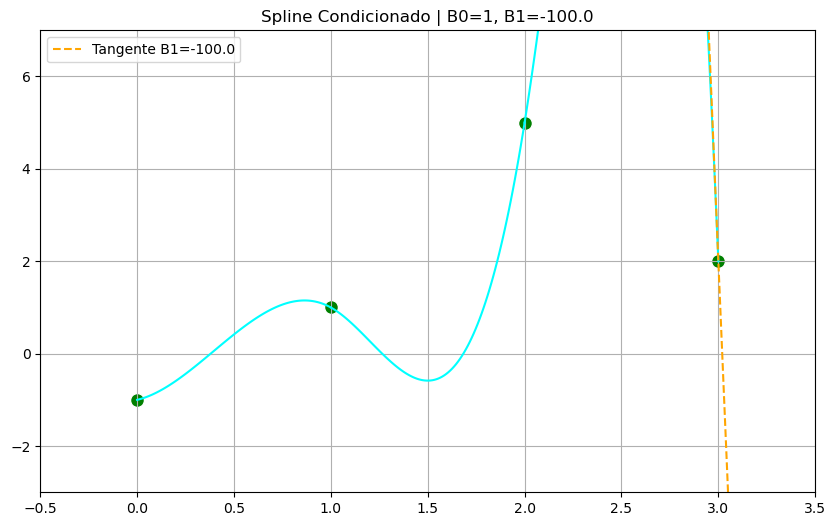

In [3]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

x = sym.Symbol("x")  # Definimos x globalmente


xs = [0, 1, 2, 3]
ys = [-1, 1,  5, 2]
x_sym = sym.Symbol("x")

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(min(xs) - 0.5, max(xs) + 0.5)
ax.set_ylim(min(ys) - 2, max(ys) + 2)
ax.set_xlabel("x")
ax.set_ylabel("y")
dots = ax.scatter(xs, ys, color="red", label="Puntos dados")
line_objs = []
B_range = np.linspace(-100, 100, 100)

def update(frame):
    ax.clear()
    B0 = 1
    B1 = B_range[frame]
    splines = cubic_spline_clamped(xs, ys, B0, B1)


    # Dibujar los splines
    for j, S in enumerate(splines):
        f = sym.lambdify(x, S, modules=["numpy"])
        x_vals = np.linspace(xs[j], xs[j + 1], 100)
        y_vals = f(x_vals)
        ax.plot(x_vals, y_vals, color="cyan")

    # Dibujar puntos originales
    ax.scatter(xs, ys, color='green', s= 100, alpha= 1, edgecolor='white')

    # Dibujar recta tangente en x = xs[-1] con pendiente B1
    x_right = xs[-1]
    y_right = ys[-1]
    x_tangent = np.linspace(x_right - 0.5, x_right + 0.5, 10)
    y_tangent = B1 * (x_tangent - x_right) + y_right
    ax.plot(x_tangent, y_tangent, 'orange', linestyle='--', label=f'Tangente B1={B1:.1f}')

    ax.set_xlim(min(xs)-0.5, max(xs)+0.5)
    ax.set_ylim(min(ys)-2, max(ys)+2)
    ax.set_title(f"Spline Condicionado | B0=1, B1={B1:.1f}", fontsize=12)
    ax.legend()
    ax.grid(True)

ani = FuncAnimation(fig, update, frames=len(B_range), interval=100)

# Guardar como GIF
ani.save("spline_animacion3.gif", writer="pillow",fps=25)

1 5 26.25 41.499999999999986 -69.74999999999999
0 1 1.0 -16.249999999999993 19.249999999999993
1 5 26.25 41.499999999999986 -69.74999999999999
0 1 1.0 -16.249999999999993 19.249999999999993
1 5 25.744949494949495 40.48989898989898 -68.23484848484848
0 1 1.0 -15.744949494949491 18.74494949494949
1 5 25.23989898989899 39.479797979797965 -66.71969696969695
0 1 1.0 -15.239898989898983 18.239898989898983
1 5 24.734848484848484 38.46969696969696 -65.20454545454545
0 1 1.0 -14.73484848484848 17.73484848484848
1 5 24.22979797979798 37.459595959595944 -63.689393939393916
0 1 1.0 -14.229797979797972 17.229797979797972
1 5 23.724747474747474 36.44949494949494 -62.174242424242415
0 1 1.0 -13.72474747474747 16.72474747474747
1 5 23.219696969696972 35.43939393939393 -60.65909090909091
0 1 1.0 -13.219696969696965 16.219696969696965
1 5 22.714646464646464 34.42929292929292 -59.143939393939384
0 1 1.0 -12.71464646464646 15.714646464646458
1 5 22.209595959595962 33.41919191919191 -57.628787878787875
0 1

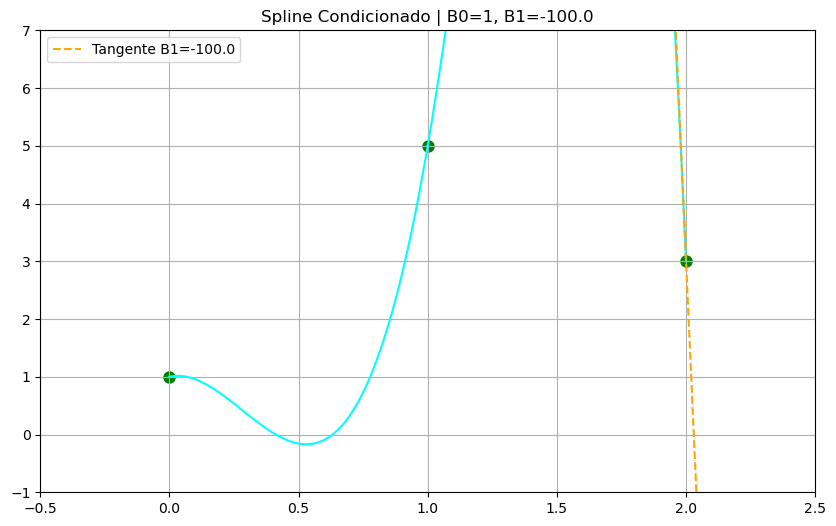

In [4]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

x = sym.Symbol("x")  # Definimos x globalmente


xs = [0, 1, 2]
ys = [1,5,3]
x_sym = sym.Symbol("x")

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(min(xs) - 0.5, max(xs) + 0.5)
ax.set_ylim(min(ys) - 2, max(ys) + 2)
ax.set_xlabel("x")
ax.set_ylabel("y")
dots = ax.scatter(xs, ys, color="red", label="Puntos dados")
line_objs = []
B_range = np.linspace(-100, 100, 100)

def update(frame):
    ax.clear()
    B0 = 1
    B1 = B_range[frame]
    splines = cubic_spline_clamped(xs, ys, B0, B1)


    # Dibujar los splines
    for j, S in enumerate(splines):
        f = sym.lambdify(x, S, modules=["numpy"])
        x_vals = np.linspace(xs[j], xs[j + 1], 100)
        y_vals = f(x_vals)
        ax.plot(x_vals, y_vals, color="cyan")

    # Dibujar puntos originales
    ax.scatter(xs, ys, color='green', s= 100, alpha= 1, edgecolor='white')

    # Dibujar recta tangente en x = xs[-1] con pendiente B1
    x_right = xs[-1]
    y_right = ys[-1]
    x_tangent = np.linspace(x_right - 0.5, x_right + 0.5, 10)
    y_tangent = B1 * (x_tangent - x_right) + y_right
    ax.plot(x_tangent, y_tangent, 'orange', linestyle='--', label=f'Tangente B1={B1:.1f}')

    ax.set_xlim(min(xs)-0.5, max(xs)+0.5)
    ax.set_ylim(min(ys)-2, max(ys)+2)
    ax.set_title(f"Spline Condicionado | B0=1, B1={B1:.1f}", fontsize=12)
    ax.legend()
    ax.grid(True)

ani = FuncAnimation(fig, update, frames=len(B_range), interval=100)

# Guardar como GIF
ani.save("spline_animacion1.gif", writer="pillow",fps=25)

1 -4 30.75 59.5 -83.25
0 -5 1.0 -29.75 29.75
1 -4 30.75 59.5 -83.25
0 -5 1.0 -29.75 29.75
1 -4 30.244949494949495 58.489898989899 -81.73484848484848
0 -5 1.0 -29.2449494949495 29.2449494949495
1 -4 29.73989898989899 57.47979797979798 -80.21969696969697
0 -5 1.0 -28.73989898989899 28.73989898989899
1 -4 29.234848484848484 56.469696969696976 -78.70454545454545
0 -5 1.0 -28.234848484848488 28.234848484848488
1 -4 28.72979797979798 55.45959595959596 -77.18939393939394
0 -5 1.0 -27.72979797979798 27.72979797979798
1 -4 28.224747474747474 54.449494949494955 -75.67424242424242
0 -5 1.0 -27.224747474747478 27.224747474747478
1 -4 27.71969696969697 53.43939393939394 -74.1590909090909
0 -5 1.0 -26.71969696969697 26.71969696969697
1 -4 27.214646464646464 52.429292929292934 -72.64393939393939
0 -5 1.0 -26.214646464646467 26.214646464646467
1 -4 26.70959595959596 51.41919191919192 -71.12878787878788
0 -5 1.0 -25.70959595959596 25.70959595959596
1 -4 26.204545454545453 50.409090909090914 -69.6136363

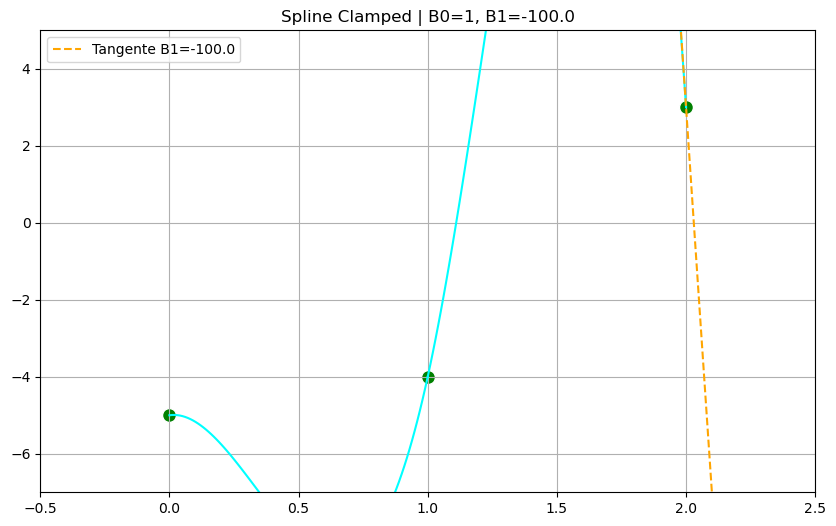

In [5]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

x = sym.Symbol("x")  # Definimos x globalmente


xs = [0, 1, 2]
ys = [-5,-4,3]
x_sym = sym.Symbol("x")

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(min(xs) - 0.5, max(xs) + 0.5)
ax.set_ylim(min(ys) - 2, max(ys) + 2)
ax.set_xlabel("x")
ax.set_ylabel("y")
dots = ax.scatter(xs, ys, color="red", label="Puntos dados")
line_objs = []
B_range = np.linspace(-100, 100, 100)

def update(frame):
    ax.clear()
    B0 = 1
    B1 = B_range[frame]
    splines = cubic_spline_clamped(xs, ys, B0, B1)


    # Dibujar los splines
    for j, S in enumerate(splines):
        f = sym.lambdify(x, S, modules=["numpy"])
        x_vals = np.linspace(xs[j], xs[j + 1], 100)
        y_vals = f(x_vals)
        ax.plot(x_vals, y_vals, color="cyan")

    # Dibujar puntos originales
    ax.scatter(xs, ys, color='green', s= 100, alpha= 1, edgecolor='white')

    # Dibujar recta tangente en x = xs[-1] con pendiente B1
    x_right = xs[-1]
    y_right = ys[-1]
    x_tangent = np.linspace(x_right - 0.5, x_right + 0.5, 10)
    y_tangent = B1 * (x_tangent - x_right) + y_right
    ax.plot(x_tangent, y_tangent, 'orange', linestyle='--', label=f'Tangente B1={B1:.1f}')

    ax.set_xlim(min(xs)-0.5, max(xs)+0.5)
    ax.set_ylim(min(ys)-2, max(ys)+2)
    ax.set_title(f"Spline Clamped | B0=1, B1={B1:.1f}", fontsize=12)
    ax.legend()
    ax.grid(True)

ani = FuncAnimation(fig, update, frames=len(B_range), interval=100)

# Guardar como GIF
ani.save("spline_animacion2.gif", writer="pillow",fps=25)